In [1]:
import geopandas as gpd
import pandas as pd
import datetime
from dateutil import tz
import stride
import folium

In [2]:
pd.options.display.max_columns = 1000
pd.options.display.max_colwidth = 1000

In [3]:
def localize_dates(data, dt_columns = []):
    data = data.copy()
    
    for c in dt_columns:
        data[c] = pd.to_datetime(data[c]).dt.tz_convert('Israel')
    
    return data

In [4]:
pd.DataFrame(stride.get('/gtfs_routes/list', {'route_short_name':490,
                                                            'agency_name': 'אגד',
                                                            'route_long_name_contains': 'ירושלים',
                                              'date_from': '2022-12-12',
                                              'date_to':  '2022-12-12'}))

,id,date,line_ref,operator_ref,route_short_name,route_long_name,route_mkt,route_direction,route_alternative,agency_name,route_type
0,1868868,2022-12-12,34316,3,490,ת.רכבת תל אביב - סבידור/רציפים B-תל אביב יפו<->ברעם/האומן-ירושלים-1#,13490,1,#,אגד,3
1,1868869,2022-12-12,34317,3,490,ברעם/האומן-ירושלים<->ת. רכבת תל אביב - סבידור/הורדה-תל אביב יפו-3#,13490,3,#,אגד,3


In [5]:
siri_locations_490_before = pd.DataFrame(stride.get('/siri_vehicle_locations/list', {
    'siri_routes__line_ref': '34317',
    'limit': -1,
    'siri_rides__schedualed_start_time_from': datetime.datetime(2022,12, 4, tzinfo=tz.gettz('Israel')),
    'siri_rides__schedualed_start_time_to': datetime.datetime(2022,12, 8, tzinfo=tz.gettz('Israel'))+datetime.timedelta(days=1),
    'order_by': 'recorded_at_time desc',
    'lon__greater_or_equal': 35.11072,
    'lon__lower_or_equal': 35.19670,
    'lat__greater_or_equal': 31.76620,
    'lat__lower_or_equal': 31.81334
}))

siri_locations_490_before.shape

(1721, 35)

In [6]:
dt_columns = ['recorded_at_time','siri_ride__scheduled_start_time']

siri_locations_490_before = localize_dates(siri_locations_490_before, dt_columns)

In [7]:
locations_490_before = siri_locations_490_before[['recorded_at_time','siri_ride__scheduled_start_time',
                                   'lon','lat','siri_ride__vehicle_ref', 'siri_ride__id', 'distance_from_journey_start', 'velocity']]

## Visualizing the data to see if nothing looks wrong

#### Now let's look at the last siri call of each ride

In [8]:
last_recs_before = locations_490_before.groupby('siri_ride__id').first()

m = folium.Map(location=[31.78,35.14], zoom_start=13, tiles='OpenStreetMap')
for i in last_recs_before.index:
    m.add_child(
        folium.Marker(
            location=[last_recs_before.lat[i], last_recs_before.lon[i]],
            popup=i
        )
    )

m

##### All the data points are after "Hemed" bus stop, except for ride #25405175

#### The same for the first siri call:

In [9]:
first_recs_before = locations_490_before.groupby('siri_ride__id').last()

m = folium.Map(location=[31.77,35.19], zoom_start=15, tiles='OpenStreetMap')
for i in first_recs_before.index:
    m.add_child(
        folium.Marker(
            location=[first_recs_before.lat[i], first_recs_before.lon[i]],
            popup=i
        )
    )

m

Strangely, there's a ride coming from Givat-Ram, but otherwise this ride follow the same route, so let's keep it.

#### Now let's create a single DF with the first and last calls for each ride

In [10]:
first_last_before = first_recs_before.join(last_recs_before, rsuffix='_last')
first_last_before.shape

(154, 14)

##### Removing the problematic ride:

In [11]:
first_last_before = first_last_before.drop(25405175)
first_last_before.shape

(153, 14)

##### Creating measures:

In [12]:
first_last_before['distance_traveled'] = first_last_before['distance_from_journey_start_last'] - first_last_before['distance_from_journey_start']
first_last_before['distance_traveled'].describe()

count      153.000000
mean      9098.810458
std        421.099497
min       8128.000000
25%       8788.000000
50%       9089.000000
75%       9448.000000
max      10157.000000
Name: distance_traveled, dtype: float64

In [13]:
first_last_before['time_traveled'] = first_last_before['recorded_at_time_last'] - first_last_before['recorded_at_time']
first_last_before['time_traveled'].describe()

count                          153
mean     0 days 00:10:17.934640522
std      0 days 00:02:14.875072469
min                0 days 00:06:59
25%                0 days 00:08:56
50%                0 days 00:09:35
75%                0 days 00:11:04
max                0 days 00:19:35
Name: time_traveled, dtype: object

In [14]:
first_last_before['mins_traveled'] = first_last_before['time_traveled'].dt.total_seconds()/60
first_last_before['ride_start_time'] = first_last_before['siri_ride__scheduled_start_time'].dt.hour + first_last_before['siri_ride__scheduled_start_time'].dt.minute/60

<AxesSubplot: xlabel='ride_start_time', ylabel='mins_traveled'>

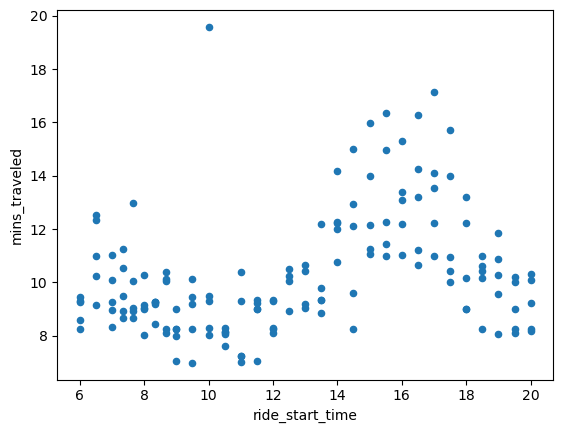

In [15]:
first_last_before.plot.scatter('ride_start_time', 'mins_traveled')

#### It seems that there's one outlier, but let's keep it for now

### Now' let's compute the average travel time based on the departure time of the bus

<AxesSubplot: xlabel='ride_start_time'>

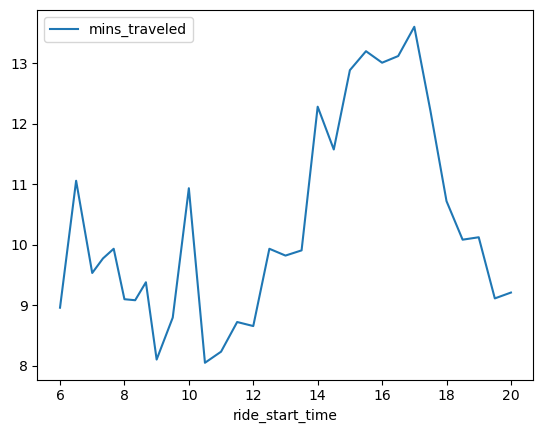

In [16]:
avgs_before = first_last_before.groupby('ride_start_time').mean(numeric_only=False).reset_index()
avgs_before.plot.line('ride_start_time', 'mins_traveled')

## Now, the same for the week after the ramp was opened

In [17]:
siri_locations_490_after = pd.DataFrame(stride.get('/siri_vehicle_locations/list', {
    'siri_routes__line_ref': '34317',
    'limit': -1,
    'siri_rides__schedualed_start_time_from': datetime.datetime(2022,12, 18, tzinfo=tz.gettz('Israel')),
    'siri_rides__schedualed_start_time_to': datetime.datetime(2022,12, 22, tzinfo=tz.gettz('Israel'))+datetime.timedelta(days=1),
    'order_by': 'recorded_at_time desc',
    'lon__greater_or_equal': 35.11072,
    'lon__lower_or_equal': 35.19670,
    'lat__greater_or_equal': 31.76620,
    'lat__lower_or_equal': 31.81334
}))

In [18]:
dt_columns = ['recorded_at_time','siri_ride__scheduled_start_time']
siri_locations_490_after = localize_dates(siri_locations_490_after, dt_columns)

In [19]:
locations_490_after = siri_locations_490_after[['recorded_at_time','siri_ride__scheduled_start_time',
                                   'lon','lat','siri_ride__vehicle_ref', 'siri_ride__id', 'distance_from_journey_start', 'velocity']]

In [20]:
last_recs_after = locations_490_after.groupby('siri_ride__id').first()

m = folium.Map(location=[31.78,35.14], zoom_start=13, tiles='OpenStreetMap')
for i in last_recs_after.index:
    m.add_child(
        folium.Marker(
            location=[last_recs_after.lat[i], last_recs_after.lon[i]],
            popup=i
        )
    )

m

##### All the data points are after "Hemed" bus stop.

#### The same for the first siri call:

In [21]:
first_recs_after = locations_490_after.groupby('siri_ride__id').last()

m = folium.Map(location=[31.77,35.19], zoom_start=15, tiles='OpenStreetMap')
for i in first_recs_after.index:
    m.add_child(
        folium.Marker(
            location=[first_recs_after.lat[i], first_recs_after.lon[i]],
            popup=i
        )
    )

m

There's one ride that went through Begin Road - #26644537

#### Combining first and last calls for each ride

In [22]:
first_last_after = first_recs_after.join(last_recs_after, rsuffix='_last')
first_last_after.shape

(147, 14)

##### Removing the problematic ride:

In [23]:
first_last_after = first_last_after.drop(26644537)
first_last_after.shape

(146, 14)

##### Creating measures:

In [24]:
first_last_after['distance_traveled'] = first_last_after['distance_from_journey_start_last'] - first_last_after['distance_from_journey_start']
first_last_after['distance_traveled'].describe()

count     146.000000
mean     9044.945205
std       847.031561
min         0.000000
25%      8819.500000
50%      9139.000000
75%      9390.750000
max      9904.000000
Name: distance_traveled, dtype: float64

### One ride with 0 distance traveled, let's find it and remove it

In [25]:
first_last_after[first_last_after['distance_traveled'] == 0]

,recorded_at_time,siri_ride__scheduled_start_time,lon,lat,siri_ride__vehicle_ref,distance_from_journey_start,velocity,recorded_at_time_last,siri_ride__scheduled_start_time_last,lon_last,lat_last,siri_ride__vehicle_ref_last,distance_from_journey_start_last,velocity_last,distance_traveled
siri_ride__id,,,,,,,,,,,,,,,
26842054,2022-12-20 18:21:09+02:00,2022-12-20 18:00:00+02:00,35.195522,31.766691,7657369,0,43,2022-12-20 18:39:25+02:00,2022-12-20 18:00:00+02:00,35.112484,31.80051,7657369,0,61,0


In [26]:
first_last_after = first_last_after.drop(26842054)
first_last_after.shape

(145, 15)

##### Recreating measures:

In [27]:
first_last_after['distance_traveled'] = first_last_after['distance_from_journey_start_last'] - first_last_after['distance_from_journey_start']
first_last_after['distance_traveled'].describe()

count     145.000000
mean     9107.324138
std       387.807313
min      8123.000000
25%      8824.000000
50%      9139.000000
75%      9393.000000
max      9904.000000
Name: distance_traveled, dtype: float64

In [28]:
first_last_after['time_traveled'] = first_last_after['recorded_at_time_last'] - first_last_after['recorded_at_time']
first_last_after['time_traveled'].describe()

count                          145
mean     0 days 00:13:31.882758620
std      0 days 00:06:43.742758852
min                0 days 00:06:58
25%                0 days 00:08:55
50%                0 days 00:10:10
75%                0 days 00:16:24
max                0 days 00:34:15
Name: time_traveled, dtype: object

In [29]:
first_last_after['mins_traveled'] = first_last_after['time_traveled'].dt.total_seconds()/60
first_last_after['ride_start_time'] = first_last_after['siri_ride__scheduled_start_time'].dt.hour + first_last_after['siri_ride__scheduled_start_time'].dt.minute/60

<AxesSubplot: xlabel='ride_start_time', ylabel='mins_traveled'>

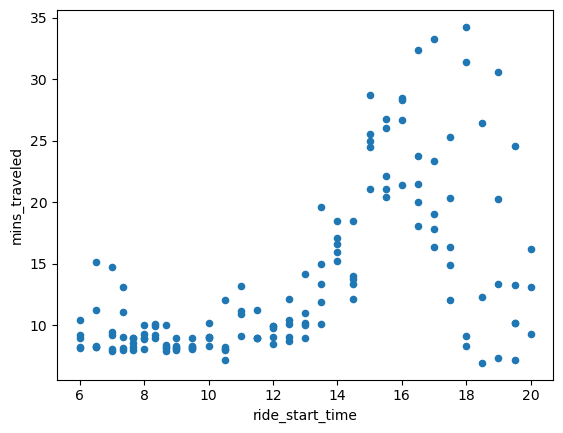

In [30]:
first_last_after.plot.scatter('ride_start_time', 'mins_traveled')

### Now' let's compute the average travel time based on the departure time of the bus

<AxesSubplot: xlabel='ride_start_time'>

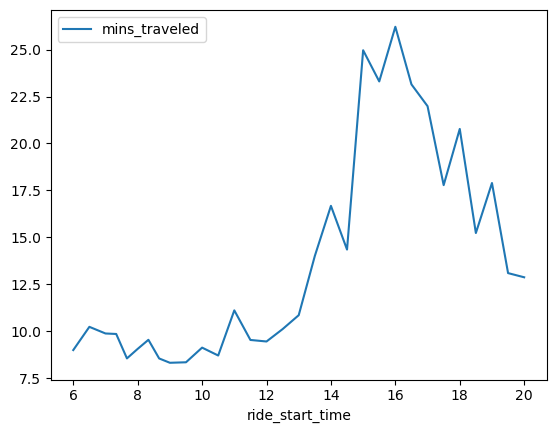

In [31]:
avgs_after = first_last_after.groupby('ride_start_time').mean(numeric_only=False).reset_index()
avgs_after.plot.line('ride_start_time', 'mins_traveled')

# Finally let's compare the two weeks

In [32]:
combined = avgs_after[['ride_start_time', 'mins_traveled']].set_index('ride_start_time').join(avgs_before[['ride_start_time', 'mins_traveled']].set_index('ride_start_time'), lsuffix='_after', rsuffix='_before')

<AxesSubplot: xlabel='ride_start_time'>

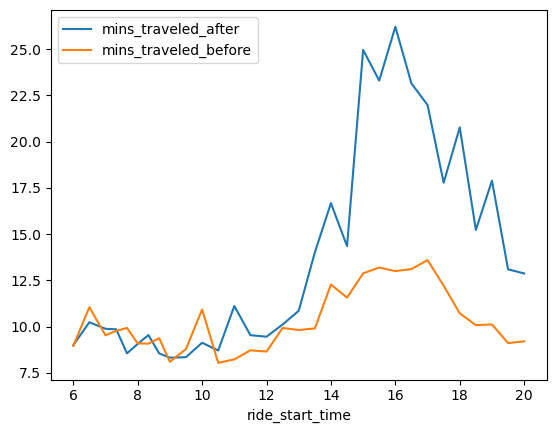

In [33]:
combined.dropna().plot.line()

# Opening the ramp added more than 10 minutes to the ride on Road 16 during PM peak hours